In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

import theano.tensor as tt
import pymc3 as pm

import exoplanet as xo
import specgp as sgp

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'
colors = [red, green, blue, yellow, darkblue]

In [25]:
with pm.Model() as model:
    trace = pm.load_trace('traces/trace3')
    mu, sig = {}, {}
    for k, v in trace[0].items():
        vals = trace.get_values(k)
        mu[k] = np.mean(vals, axis=0)
        sig[k] = np.std(vals, axis=0)
        
#ppm = np.array([10, 8, 6])
#mu['logsig'] = np.log(ppm * 1e-3)

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


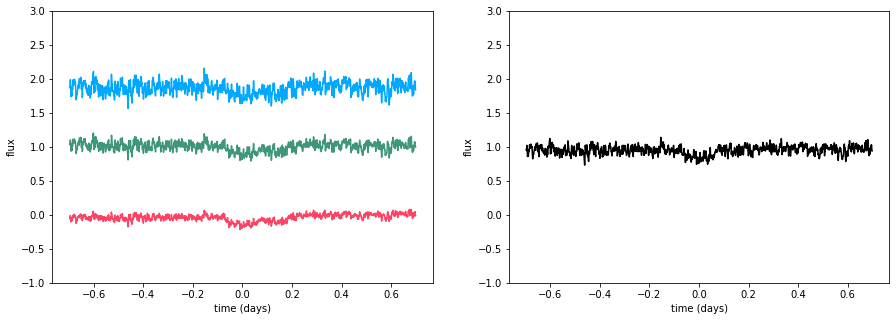

In [26]:
from astropy.io import fits
from astropy.time import Time

blue = fits.open('soho/blue.fits')
green = fits.open('soho/green.fits')
red = fits.open('soho/red.fits')
rgb = red, green, blue

rgb = [f[0].data for f in rgb]
mask = np.all([np.isfinite(f) for f in rgb], axis=0)

start = blue[0].header['DATES'][0:9]
end = blue[0].header['DATES'][14:]
start, end = Time([start, end]).jd
t = np.linspace(start, end, np.shape(rgb)[1]) - start

t = t[mask]
rgb = [f[mask].astype('float64') for f in rgb]
flux = np.sum(rgb, axis=0)/np.shape(rgb)[0]

# choose an arbitrary starting index and number of points to 
# select a segment of the (very large) SOHO timeseries 
i = 98765
n = 2000
t = t[i:i+n] - np.mean(t[i:i+n])
# in units of parts per thousand 
rgb = [f[i:i+n]/1e3 for f in rgb]

# add artificial white noise to the SOHO data in order 
# to make the model numerically stable.
rgb += np.random.randn(3, n) * np.exp(-5)
r, g, b = rgb

rm = 0.003 + np.random.rand() * 0.005
tm = -0.3 + np.random.rand() * 0.6
np.savetxt("input.dat", (rm, tm))

orbit = xo.orbits.KeplerianOrbit(period=5.0)
u = [0.3, 0.2]
planet = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.01, t=t, texp=0.02)
    .eval()
).T[0] * 1e3
moon = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=rm , t=t-tm, texp=0.02)
    .eval()
).T[0] * 1e3

mean = planet + moon
mean = np.tile(mean, (3, 1))
obs = rgb + mean
obs = np.reshape(obs.T, (3*len(t)))

fig, ax = pl.subplots(1, 2, figsize=(15, 5))

ax[0].plot(t, r + planet + moon, '-', color=colors[0])
ax[0].plot(t, g+1 + planet + moon, '-', color=colors[1])
ax[0].plot(t, b+2 + planet + moon, '-', color=colors[2])
ax[0].set_ylim(-1, 3)

ax[1].plot(t, np.mean([r, g, b], axis=0)+1 + planet, '-', color='k')
ax[1].set_ylim(-1, 3)

[x.set_ylabel('flux') for x in ax]
[x.set_xlabel('time (days)') for x in ax]

term1 = xo.gp.terms.SHOTerm(log_S0=mu["logS0"][0], 
                            log_w0=mu["logw"][0], 
                            log_Q=-np.log(np.sqrt(2))
                            )
term2 = xo.gp.terms.SHOTerm(log_S0=mu["logS0"][1], 
                            log_w0=mu["logw"][1], 
                            log_Q=mu["logQ"]
                            )
alpha1 = np.exp([0, mu["alpha1"][0], mu["alpha2"][0]])
alpha2 = np.exp([0, mu["alpha1"][1], mu["alpha2"][1]])
kernel = (sgp.terms.KronTerm(term1, alpha=alpha1) + 
          sgp.terms.KronTerm(term2, alpha=alpha2))

t = np.linspace(-1, 1, 1000)
logsig = np.array(mu["logsig"])
diag = np.exp(2*logsig)[:, None] * np.ones((3, len(t)))
mean = mu["mean"][:, None] * np.ones_like(t)
gp3 = xo.gp.GP(x=t, kernel=kernel, diag=diag, mean=sgp.means.KronMean(mean), J=4)

In [29]:
with pm.Model() as model:
    
    logS0 = pm.MvNormal("logS0", mu=mu["logS0"], 
                        chol=np.diag(sig["logS0"]), shape=2)
    logw = pm.MvNormal("logw", mu=mu["logw"], 
                       chol=np.diag(sig["logw"]), shape=2)
    logQ = pm.Normal("logQ", mu=mu["logQ"], sd=sig["logQ"])
    alpha1 =  pm.MvNormal("alpha1", mu=mu["alpha1"], 
                          chol=np.diag(sig["alpha1"]), shape=2)
    alpha2 =  pm.MvNormal("alpha2", mu=mu["alpha2"], 
                          chol=np.diag(sig["alpha2"]), shape=2)
    logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=3)
    mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=3)
    u = sgp.distributions.MvUniform("u", lower=[0, 0], upper=[1, 1], testval=[0.5, 0.5])
    logr = pm.Uniform("logr", lower=-20.0, upper=0.0, testval=np.log(0.01))
    t0 = pm.Uniform("t0", lower=-1, upper=1, testval=0.0)
    
    orbit = xo.orbits.KeplerianOrbit(period=5.0)
    lc = (xo.LimbDarkLightCurve(u)
          .get_light_curve(orbit=orbit, r=tt.exp(logr), t=t-t0, texp=0.02)
          *1e3)
    mean = mean[:, None] + lc.T[0]
    
    term1 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[0],
        log_w0 = logw[0],
        log_Q = -np.log(np.sqrt(2))
    )
    term2 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[1],
        log_w0 = logw[1],
        log_Q = logQ
    )
        
    a1 = tt.exp(tt.stack([0.0, alpha1[0], alpha2[0]]))
    a2 = tt.exp(tt.stack([0.0, alpha1[1], alpha2[1]]))
        
    kernel = (sgp.terms.KronTerm(term1, alpha=a1) + 
              sgp.terms.KronTerm(term2, alpha=a2))
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr[:, None] * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr, J=4, mean=sgp.means.KronMean(mean))
    gp.marginal("gp", observed = obs.T)

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


ValueError: Input dimension mis-match. (input[0].shape[0] = 6000, input[1].shape[0] = 3000)

In [15]:
with pm.Model() as model:
    
    t0 = np.linspace(-0.6, 0.6, 100)
    ll = np.zeros(len(t0))
    for i, t0 in enumerate(t0):
        print('{0}'.format(i), end='')
        orbit = xo.orbits.KeplerianOrbit(period=5.0)
        mean = (xo.LimbDarkLightCurve([0.2, 0.3])
          .get_light_curve(orbit=orbit, r=0.004, t=t-t0, texp=0.02)*1e3).T[0]
        mean = tt.ones(3)[:, None] * mean
        lp = model.logp(mu)
        print(lp)
        ll[i] = lp

0

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
160.0
170.0
180.0
190.0
20

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (1,) and (100,)

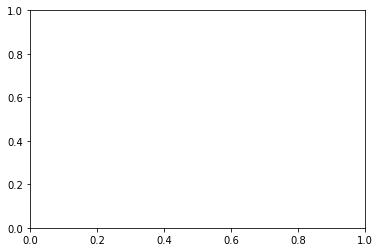

In [11]:
pl.plot(t0, ll)

In [14]:
ll

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])